<a href="https://colab.research.google.com/github/Motz224/Pokemon_DCGANModel_20230803/blob/main/Pokemon_GANModel_20230803.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
#Constant
BATCH_SIZE = 16
IMAGE_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#load image
import pathlib

_URL = "https://pds-workshop-data.s3.ap-southeast-1.amazonaws.com/pokemon_jpg.zip"
path_to_zip = tf.keras.utils.get_file(
    fname="pokemon_jpg.zip",
    origin=_URL,
    extract=True)
path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent / "pokemon_jpg"

train_dataset = tf.keras.utils.image_dataset_from_directory(
  PATH,
  labels=None,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)
train_dataset

33236017/33236017 [==============================] - 3s 0us/step
Found 819 files belonging to 1 classes.


<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
# [updated by Jason] missing pre-processing
def preprocess(image_batch):
  image_batch = tf.cast(image_batch, tf.float32)
  image_batch = image_batch / 127.5 - 1
  return image_batch

train_dataset = train_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

In [ ]:
!ls /root/.keras/datasets/pokemon_jpg

100.jpg		  266.jpg	    423-west.jpg	  58.jpg
101.jpg		  267.jpg	    424.jpg		  590.jpg
102.jpg		  268.jpg	    425.jpg		  591.jpg
103.jpg		  269.jpg	    426.jpg		  592f.jpg
104.jpg		  26.jpg	    427.jpg		  592.jpg
105.jpg		  270.jpg	    428.jpg		  593f.jpg
106.jpg		  271.jpg	    428-mega.jpg	  593.jpg
107.jpg		  272.jpg	    429.jpg		  594.jpg
108.jpg		  273.jpg	    42.jpg		  595.jpg
109.jpg		  274.jpg	    430.jpg		  596.jpg
10.jpg		  275.jpg	    431.jpg		  597.jpg
110.jpg		  276.jpg	    432.jpg		  598.jpg
111.jpg		  277.jpg	    433.jpg		  599.jpg
112.jpg		  278.jpg	    434.jpg		  59.jpg
113.jpg		  279.jpg	    435.jpg		  5.jpg
114.jpg		  27.jpg	    436.jpg		  600.jpg
115.jpg		  280.jpg	    437.jpg		  601.jpg
115-mega.jpg	  281.jpg	    438.jpg		  602.jpg
116.jpg		  282.jpg	    439.jpg		  603.jpg
117.jpg		  282-mega.jpg	    43.jpg		  604.jpg
118.jpg		  283.jpg	    440.jpg		  605.jpg
119.jpg		  284.jpg	    441.jpg		  606.jpg
11.jpg		  285.jpg	    442.jpg		  607.jpg
120.jpg		  286.jpg	    44

In [ ]:
def make_generator_model():
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=[noise_dim,]))

  model.add(layers.Dense(8*8*1024, use_bias=False))
  model.add(layers.Reshape((8, 8, 1024)))
  assert model.output_shape == (None, 8, 8, 1024)

  model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 16, 16, 512)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 32, 32, 256)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 64, 64, 128)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 128, 128, 64)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same',kernel_initializer=initializer, use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 128, 128, 3)

  return model

In [ ]:
def make_discriminator_model():
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=[128,128,3]))

  model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(1024, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6553600   
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      13107200  
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 512)      2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      3

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        4800      
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                      

In [ ]:
# checkpoint_dir = './drive/MyDrive/projects/training_checkpoints'
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      #plt.imshow(predictions[0, :, :,:])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    # images, label = images_data
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [ ]:
#restore checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
EPOCHS = 500

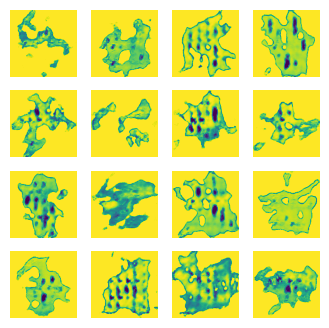

Time for epoch 238 is 21.36201572418213 sec


KeyboardInterrupt: ignored

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
#processing gif
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

!pip install -q git+https://github.com/MJAHMADEE/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

<ipython-input-22-1eb83e015288>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-22-1eb83e015288>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


tf.Tensor([[0.00055055]], shape=(1, 1), dtype=float32)


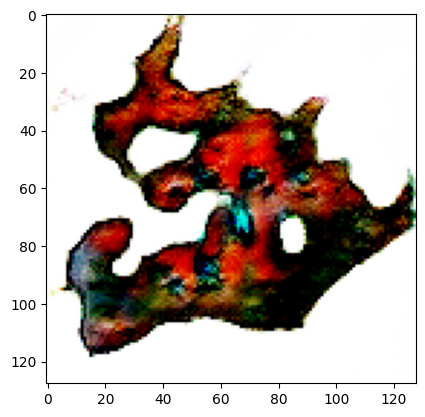

In [ ]:
#Generate
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :,:])

decision = discriminator(generated_image)
print (decision)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
